# Support Vector Machine (SVM)


This notebook provides and example of how to use SML to read in a dataset, split split the dataset into training and testing data, and perform classification on the dataset. For this use-case we use the publicly aviliable [iris dataset](http://archive.ics.uci.edu/ml/datasets/Iris) to predict the class of iris plants.

## SML Query

### Imports

We import the nescessary library to use SML. 

In [1]:
from sml import execute

### Query

Next we create a query statement to `READ` the iris dataset, perform a 80%/20% `SPLIT` on the dataset for the training and testing set respectively, we use the algorithm SVM to prdict the 5th column in the dataset using columns 1-4 as the features, and lastly we execute the statement.

In [2]:
query = 'READ "../data/iris.csv" AND \
 SPLIT (train = .8, test = 0.2) AND \
 CLASSIFY (predictors = [1,2,3,4], label = 5, algorithm = svm)'

execute(query)

## Manually

The subsequent ceels below show how the same actions of a SML query can be performed manually.

### IMPORTS

We begin by importing the necessary statements libraries needed to perform the same actions as the SML query above.

In [3]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import label_binarize
import sklearn.cross_validation as cv
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### READ
 
 Next we read in the dataset into a pandas dataframe, by default this dataset does not contain a header, so we manually specify this.

In [4]:
names = ['sepal length(cm)', 'sepal width(cm)', 'petal length(cm)', 'petal width(cm)', 'species']
data = pd.read_csv('../data/iris.csv', names=names)

### Preprocessing

Next we seperate the features from the labels. Lastly, we binarize the data so that it is possible to generate metrics such as ROC curves, and identify all of the classes in the iris dataset. .

In [6]:
iris_classes = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
features = np.c_[data.drop('species',1).values]
labels = label_binarize(data['species'], classes=iris_classes)

n_classes = labels.shape[1]

### SPLIT

We then split the dataset using 75% of it for the training set and 25% for testing set.

In [7]:
(x_train, x_test, y_train, y_test) = cv.train_test_split(features, labels, test_size=0.25)

### CLASSIFY
#### Training

Next we create a svm model and fit it on the training data.

In [8]:
svm = OneVsRestClassifier(SVC(kernel='linear', probability=True))
model = svm.fit(x_train, y_train)

#### Testing
Next we make predictions on the testing data with our trained model and report the accuracy of our model's prediction.

In [9]:
predict_score = model.decision_function(x_test)
test_set_results = model.score(x_test, y_test) * 100
print ('SVM Prediction Accuracy = {0:6.2f}%'.format(test_set_results) )

SVM Prediction Accuracy =  78.95%


### Generate ROC Curves

Next we generate the ROC Curves from our predictions on the testing dataset

In [10]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
	fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predict_score[:, i])
	roc_auc[i] = auc(fpr[i], tpr[i])

### PLOT

#### Plot Dataset 
We generate lattice plots for the dataset , and specify the columns that we want we want in the lattice plot.

/Users/jarvis/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


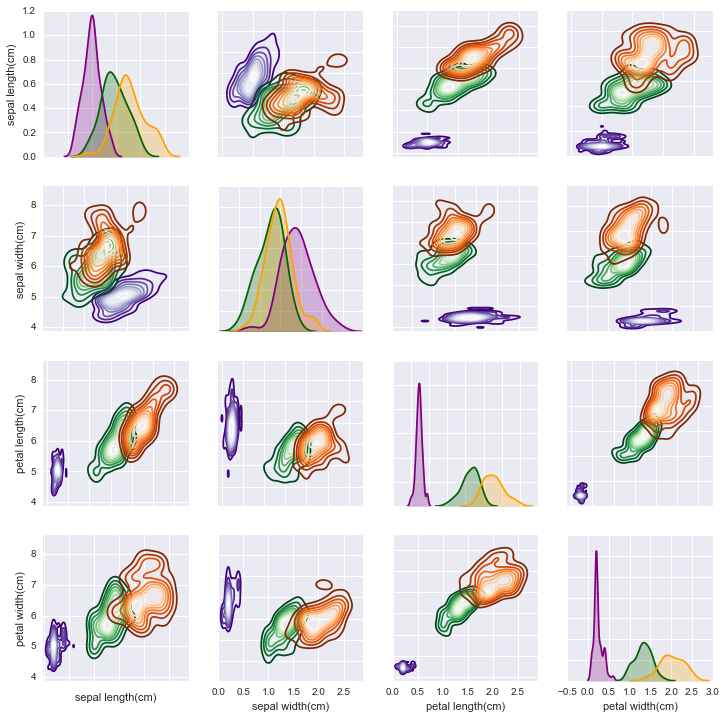

In [13]:
sns.set()
plt.rcParams['figure.figsize']=(12,12)

# Class Info
columns = [0,1,2,3]
cmap_class = ['Purples_r', 'Greens_r', 'Oranges_r', 'Greys_r' ]
color_class1D = ['purple', 'darkgreen', 'orange', 'grey']
column_headers =  data.columns.values.tolist() # Grab headers from df
column_headers = [column_headers[x] for x in columns] # Map headers to indices selected

label = 'species'
fig, ax = plt.subplots(len(columns), len(columns))

for ic, cc, cc1D in zip(iris_classes, cmap_class, color_class1D): # Iterate through for each class
    iris_class_data = data.loc[data.species == ic] # sep class
    
    #Generate kde plot matrix for class
    for col1, i in enumerate(columns):
        for col2, j in enumerate(columns):
            if i == j:
                sns.kdeplot(iris_class_data[iris_class_data.columns[col1]], ax=ax[col1][col2], color=cc1D, shade=True, legend=False)
            else:
                sns.kdeplot( iris_class_data[iris_class_data.columns[col1]], iris_class_data[iris_class_data.columns[col2]], ax=ax[col1][col2], cmap=cc)
            
            # Formatting
            if j == 0:
                ax[i,j].set_xticklabels([])
                ax[i,j].set_ylabel(column_headers[i])
                ax[i,j].set_xlabel('')
                if i == len(columns)-1:
                    ax[i,j].set_xlabel(column_headers[j])
            elif i == len(columns)-1:
                ax[i,j].tick_params(axis='y', which='major', bottom='off')
                ax[i,j].set_yticklabels([])
                ax[i,j].set_xlabel(column_headers[j])
                ax[i,j].set_ylabel('')                
            else:
                ax[i,j].set_xticklabels([])
                ax[i,j].set_xlabel('')
                
                ax[i,j].set_yticklabels([])
                ax[i,j].set_ylabel('')
    
plt.show()
plt.close()

### Plot ROC Curves 

Lastly, we plot of the ROC Curve for each class.

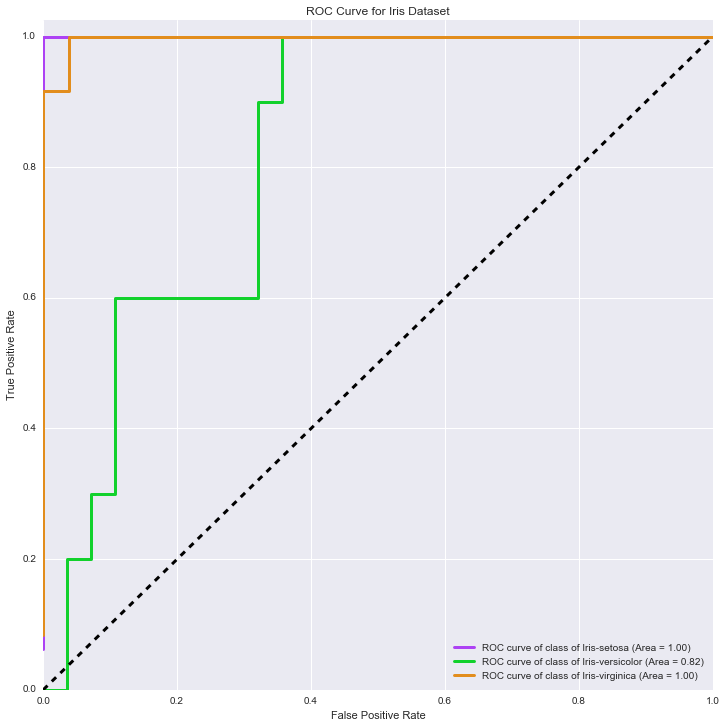

In [15]:
matplotlib_colors = ['#ad42f4', '#12d12c', '#e28d1d']  # Hex values for colors
line_width = 3
for i in range(n_classes):
	plt.plot(fpr[i], tpr[i], c=matplotlib_colors[i], lw=line_width, label='ROC curve of class of {0} (Area = {1:0.2f})'.format(iris_classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=line_width)
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.025])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Iris Dataset')
plt.legend(loc="lower right")
#plt.savefig('iris_roc.png', dpi=300)
plt.show()
plt.close()